# **위성 데이터를 이용하여 과학 데이터 재생산**

## 프로젝트 목표

1.   딥러닝을 이용하여 위성 데이터 이진분류

2.   위성 데이터를 이용하여 과학적인 데이터 재생산



## 프로젝트 개요
지구 근처에서의 플라즈마 상태를 정확히 파악하는 것은 우주환경 예보에서 중요한 역할입니다. 하지만 태양에서 불어오는 태양풍과 지구 자기장의 상호작용으로 생각보다 복잡하고 비선형적인 변화를 야기합니다.

때문에 우주환경을 위한 위성에서는 많은 기기를 탑재하고 따라서 많은 비용이 발생합니다. 이번 프로젝트에서는 단순히 태양풍 플라즈마의 상태를 나타내는 데이터를 이용하여 과학적으로 의미가 있는 이온의 비율을 나타내는 데이터로 재생산하는 모델을 구성합니다.

더 나아가 좋은 결과가 나온다면 현재 진행하고 있는 저의 석사 연구에도 적용하여 좀 더 진행 해볼 예정입니다.

## 1. 라이브러리 불러오기

In [1]:
# 구글 코랩을 이용하여 프로젝트 진행
from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 텐서플로우 애드온 추가
!pip install tensorflow-addons

# 시드와 경로 변경을 위한 라이브러리
import os,sys, random

# 경로 변경
os.chdir('drive/MyDrive/Elice프로젝트')

     |████████████████████████████████| 1.1 MB 10.1 MB/s 


In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
from datetime import datetime, timedelta

## 2. 데이터 전처리

2.1. Heliopy 라이브러리를 이용하여 데이터를 미리 다운로드하여 "ace_1998.csv","ace_1999.csv","ace_2000.csv"로 데이터를 구성합니다.

2.2. 1998년 데이터만 info, head를 통해 대략적인 데이터를 파악합니다.

2.3. resample 메서드를 이용하여 1시간으로 평균 데이터를 구성하고 "1hour_ace_1998.csv","1hour_ace_1999.csv","1hour_ace_2000.csv"로 저장합니다.

In [4]:
csv_list = ["ace_1998.csv","ace_1999.csv","ace_2000.csv"]

for name in csv_list:
  year = name[4:8]
  df = pd.read_csv(name,index_col='Time',parse_dates=True)

  if int(year) == 1998:
    print(df.info())
    print(df.head(5))
  else:
    pass

  averge = df.resample('1H').mean()

#  averge.to_csv("1hour_"+name)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 529556 entries, 1998-01-01 00:00:00 to 1998-12-31 23:39:59
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Magnitude   517701 non-null  float64
 1   BRTN_0      517701 non-null  float64
 2   BRTN_1      517701 non-null  float64
 3   BRTN_2      517701 non-null  float64
 4   Np          384961 non-null  float64
 5   Vp          405656 non-null  float64
 6   Tpr         384809 non-null  float64
 7   V_RTN_0     404694 non-null  float64
 8   V_RTN_1     404694 non-null  float64
 9   V_RTN_2     404694 non-null  float64
 10  C6to5       6381 non-null    float64
 11  C6to5_qual  7903 non-null    float64
 12  O7to6       6418 non-null    float64
 13  O7to6_qual  7903 non-null    float64
 14  SW_type     7903 non-null    float64
dtypes: float64(15)
memory usage: 64.6 MB
None
                     Magnitude    BRTN_0    BRTN_1    BRTN_2  Np  Vp  Tpr  \
Time             

2.4.1. 데이터를 불러오고 필요한 변수만을 선택하는 함수를 정의합니다.

In [5]:
def data_set(file_name):
  df = pd.read_csv(file_name,index_col='Time',parse_dates=True).dropna(axis=0)
  df = df[(df['SW_type'] == 0)|(df['SW_type'] == 1)] 
  df = df[(df['O7to6_qual'] == 0)]

  print(df.head(5))

  k = 8.617*10**(-5);m = 1.67*10**(-24) #g

  # 새로운 변수를 정의합니다. 플라즈마에서 중요한 "엔트로피"라는 변수입니다.
  df['entro'] = (k*df['Tpr'])/df['Np']**(2/3)

  X = df.drop(columns=['C6to5', 'C6to5_qual', 'O7to6', 'O7to6_qual','SW_type'])
  Y = df[['C6to5', 'C6to5_qual', 'O7to6', 'O7to6_qual','SW_type']]
  
  return X,Y

2.4.2. confusion matrix를 그려주는 함수를 정의합니다.

In [6]:
def c_matrix(matrix):
  plt.rcParams['figure.figsize'] = (5, 5)
  sns.set(font_scale = 2)

  ax = sns.heatmap(matrix, annot=True)
  plt.xlabel('Prediction')
  plt.ylabel('Real Data')
  ax.set_xticklabels((0,1))
  ax.set_yticklabels((0,1))
  print(matrix)
  plt.show()

2.5. 1998년, 1999년 데이터를 train 데이터로 이용합니다.

2.6. train/validation데이터를 8:2로 분리하고, StandardScaler를 통해서 데이터의 스케일을 조정합니다.

                     Magnitude     BRTN_0    BRTN_1    BRTN_2         Np  \
Time                                                                       
1998-02-05 00:00:00  13.726127 -13.358070  0.105694  3.090762  16.655087   
1998-02-05 02:00:00  13.184360 -12.066559  1.597152  4.858430  18.678900   
1998-02-05 03:00:00  13.028030 -11.595308  1.887177  5.533726  18.480766   
1998-02-05 07:00:00  10.911599  -8.937269  1.824383  5.951695  28.750287   
1998-02-05 08:00:00   9.770036  -7.733318  2.071796  5.584424  31.155558   

                             Vp           Tpr     V_RTN_0    V_RTN_1  \
Time                                                                   
1998-02-05 00:00:00  323.896667   9529.141818  323.862500   1.624889   
1998-02-05 02:00:00  324.607037   9559.362963  324.533333   1.702870   
1998-02-05 03:00:00  322.684906   8965.915094  322.112321 -15.897547   
1998-02-05 07:00:00  309.935370  12476.738889  309.836340  -6.516302   
1998-02-05 08:00:00  307.504717  14

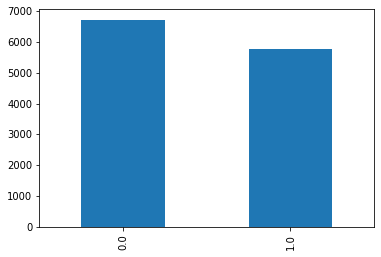

In [7]:
para = ['Magnitude' , 'Np', 'Vp', 'Tpr','entro']
# 차례대로 자기장의 세기, 플라즈마의 밀도, 플라즈마의 속도, 플라즈마의 온도, 엔트로피를 뜻함

train_X_1998, train_Y_1998 = data_set("1hour_ace_1998.csv")
train_X_1999, train_Y_1999 = data_set("1hour_ace_1999.csv")

train_XX = pd.concat([train_X_1998,train_X_1999]);train_YY = pd.concat([train_Y_1998,train_Y_1999])

# 데이터의 전체적인 분포 파악
print(train_YY['SW_type'].value_counts())
train_YY['SW_type'].value_counts().plot(kind='bar')

# 데이터가 0인 경우 : "Streamer Wind", 1인 경우 : "Coronal Hole Wind"로 분류합니다.

# 데이터의 분포를 로그 스케일로 지정
X = np.log10(train_XX[para])
Y = train_YY['SW_type'].astype(int)

# 시드를 고정합니다
SEED = 0
train_X,valid_X,train_Y,valid_Y = train_test_split(X,Y,test_size=0.2, shuffle=True, stratify=Y, random_state=SEED)

sc = StandardScaler()

train_X = sc.fit_transform(train_X)
valid_X = sc.transform(valid_X)

2.7. test 데이터도 위와 같이 구성해줍니다.

In [8]:
test_XX, test_YY = data_set("1hour_ace_2000.csv")

test_X = np.log10(test_XX[para])
test_Y = test_YY['SW_type'].astype(int)

test_X = sc.transform(test_X)

                     Magnitude    BRTN_0    BRTN_1    BRTN_2        Np  \
Time                                                                     
2000-01-01 00:00:00   8.013428  5.871203 -3.520002 -1.449718  3.467889   
2000-01-01 01:00:00   7.627232  3.187808 -5.077449 -3.069814  2.898587   
2000-01-01 02:00:00   7.617455  3.693550 -4.640820 -2.039617  2.577767   
2000-01-01 03:00:00   7.146972  2.879958 -2.143100 -1.959327  2.542500   
2000-01-01 04:00:00   6.753734  4.332838 -1.710029 -0.425975  2.453050   

                             Vp            Tpr     V_RTN_0    V_RTN_1  \
Time                                                                    
2000-01-01 00:00:00  671.577358  246138.627778  670.655868  -9.082717   
2000-01-01 01:00:00  695.252830  282112.007547  694.646189   1.285415   
2000-01-01 02:00:00  706.356727  305717.433333  704.984927  -2.654018   
2000-01-01 03:00:00  724.177593  351594.259259  721.181370 -30.588352   
2000-01-01 04:00:00  713.846667  357005.865

## 3. 데이터 훈련 및 결과

3.1. 텐서 플로우 라이브러리 불러오기 및 시드 고정

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

3.2. 배치 사이즈 및 모델 세팅 -> 데이터 훈련

In [10]:
train_dt = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
train_dt = train_dt.shuffle(len(train_X)).batch(batch_size=256)

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_dim=5, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [12]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(train_dt, epochs=50, verbose=2,validation_data=(valid_X,valid_Y))

Epoch 1/50
40/40 - 1s - loss: 0.5264 - accuracy: 0.7785 - val_loss: 0.5014 - val_accuracy: 0.7870 - 1s/epoch - 26ms/step
Epoch 2/50
40/40 - 0s - loss: 0.4846 - accuracy: 0.7814 - val_loss: 0.4721 - val_accuracy: 0.7878 - 124ms/epoch - 3ms/step
Epoch 3/50
40/40 - 0s - loss: 0.4680 - accuracy: 0.7857 - val_loss: 0.4627 - val_accuracy: 0.7898 - 238ms/epoch - 6ms/step
Epoch 4/50
40/40 - 0s - loss: 0.4613 - accuracy: 0.7886 - val_loss: 0.4545 - val_accuracy: 0.7914 - 266ms/epoch - 7ms/step
Epoch 5/50
40/40 - 0s - loss: 0.4569 - accuracy: 0.7888 - val_loss: 0.4494 - val_accuracy: 0.7950 - 293ms/epoch - 7ms/step
Epoch 6/50
40/40 - 0s - loss: 0.4537 - accuracy: 0.7896 - val_loss: 0.4451 - val_accuracy: 0.7966 - 274ms/epoch - 7ms/step
Epoch 7/50
40/40 - 0s - loss: 0.4512 - accuracy: 0.7906 - val_loss: 0.4420 - val_accuracy: 0.7986 - 300ms/epoch - 7ms/step
Epoch 8/50
40/40 - 0s - loss: 0.4493 - accuracy: 0.7915 - val_loss: 0.4405 - val_accuracy: 0.7978 - 237ms/epoch - 6ms/step
Epoch 9/50
40/40 -

3.3. epoch당 정확도와 loss변화 파악하기

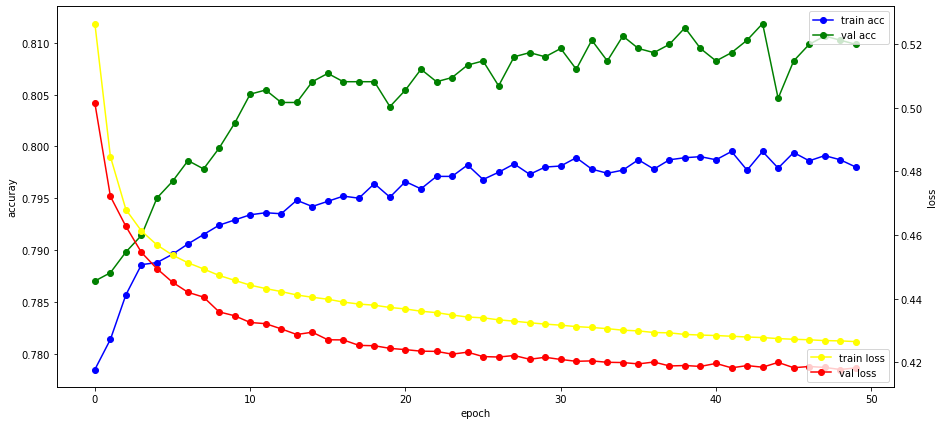

In [13]:
history = pd.DataFrame(history.history)

fig, acc_ax = plt.subplots(figsize=(15,7))

loss_ax = acc_ax.twinx()

acc_ax.plot(history['accuracy'], color='blue',marker='o',label='train acc')
acc_ax.plot(history['val_accuracy'], color='green',marker='o', label='val acc')

loss_ax.plot(history['loss'], color='yellow',marker='o', label='train loss')
loss_ax.plot(history['val_loss'], color='red',marker='o', label='val loss')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuray')
loss_ax.set_ylabel('loss')

acc_ax.legend(loc='upper right')
loss_ax.legend(loc='lower right')

plt.show()

3.4. 실제값과 예측값을 비교하기

In [14]:
loss, acc = model.evaluate(test_X, test_Y)

predictions = model.predict(test_X)

print("테스트 데이터의 Accuracy 값: ", acc)
for i in range(10):
    print("%d 번째 데이터의 [실제값,예측값] : [%d,%d]"\
          % (i, test_Y.iloc[i],np.around(predictions[i])))

188/188 [==============================] - 0s 1ms/step - loss: 0.4129 - accuracy: 0.8152
테스트 데이터의 Accuracy 값:  0.8152409791946411
0 번째 데이터의 [실제값,예측값] : [1,1]
1 번째 데이터의 [실제값,예측값] : [1,1]
2 번째 데이터의 [실제값,예측값] : [1,1]
3 번째 데이터의 [실제값,예측값] : [1,1]
4 번째 데이터의 [실제값,예측값] : [1,1]
5 번째 데이터의 [실제값,예측값] : [1,1]
6 번째 데이터의 [실제값,예측값] : [1,1]
7 번째 데이터의 [실제값,예측값] : [1,1]
8 번째 데이터의 [실제값,예측값] : [1,1]
9 번째 데이터의 [실제값,예측값] : [1,1]


[[2560  563]
 [ 545 2329]]


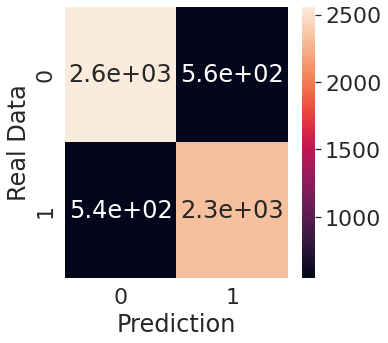

In [15]:
d_cm = confusion_matrix(test_Y, np.around(predictions))

c_matrix(d_cm)

Text(0.5, 1.0, 'Not Correct')

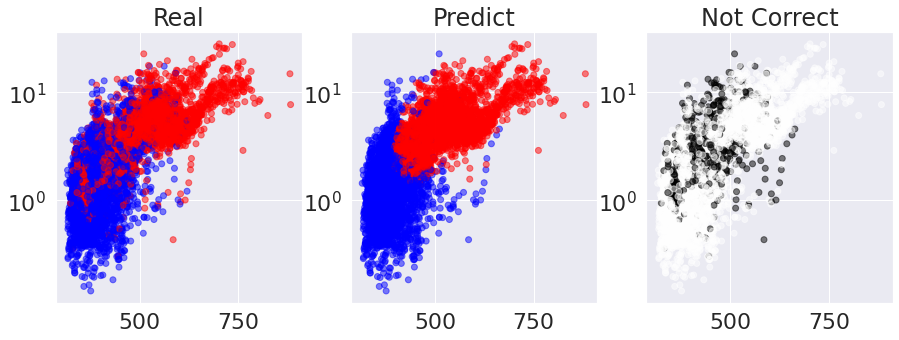

In [16]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

tftf = (test_YY['SW_type'] == np.around(predictions).flatten())

ax[0].scatter(test_XX['Vp'],test_XX['entro'],c=test_YY['SW_type'],cmap='bwr',alpha=0.5)
ax[1].scatter(test_XX['Vp'],test_XX['entro'],c=np.around(predictions),cmap='bwr',alpha=0.5)
ax[2].scatter(test_XX['Vp'],test_XX['entro'],c=tftf,cmap='gray',alpha=0.5)
ax[0].set_yscale('log');ax[1].set_yscale('log');ax[2].set_yscale('log')
ax[0].set_title('Real');ax[1].set_title('Predict');ax[2].set_title('Not Correct')

## 4. 과학적인 데이터 재생산을 위해 데이터 전처리

4.1. 여기서는 07to6라는 산소 이온 비율을 플라즈마 상태만으로 추정 해보겠습니다.

4.2. 위와 같은 방법으로 데이터 전처리 시도

In [17]:
X0 = np.log10(train_XX[para])
test_X0 = np.log10(test_XX[para])

Y0 = np.log10(train_YY['O7to6']) ; test_Y0 = np.log10(test_YY['O7to6'])

train_X0,valid_X0,train_Y0,valid_Y0 = train_test_split(X0,Y0,test_size=0.2, shuffle=True, random_state=0)

reg_sc = StandardScaler()

train_X0 = reg_sc.fit_transform(train_X0)
valid_X0 = reg_sc.transform(valid_X0)
test_X0 = reg_sc.transform(test_X0)

## 5. 데이터 훈련 및 결과

5.1. 이온 비율은 다중 회귀를 통해서 정확한 추정을 해야하므로 딥러닝 모델에서 노드를 많이 설정합니다.

In [18]:
train_dt0 = tf.data.Dataset.from_tensor_slices((train_X0, train_Y0))
train_dt0 = train_dt0.shuffle(len(train_X0)).batch(batch_size=512)

In [19]:
reg_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_dim=5, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
    ])

In [20]:
reg_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
reg_history = reg_model.fit(train_dt0, epochs=50, verbose=2,validation_data=(valid_X0,valid_Y0))

Epoch 1/50
20/20 - 1s - loss: 0.3019 - mae: 0.4450 - val_loss: 0.1554 - val_mae: 0.3102 - 587ms/epoch - 29ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1374 - mae: 0.2967 - val_loss: 0.1151 - val_mae: 0.2770 - 132ms/epoch - 7ms/step
Epoch 3/50
20/20 - 0s - loss: 0.1012 - mae: 0.2551 - val_loss: 0.0858 - val_mae: 0.2353 - 142ms/epoch - 7ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0789 - mae: 0.2236 - val_loss: 0.0695 - val_mae: 0.2103 - 147ms/epoch - 7ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0645 - mae: 0.2008 - val_loss: 0.0594 - val_mae: 0.1937 - 144ms/epoch - 7ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0565 - mae: 0.1873 - val_loss: 0.0543 - val_mae: 0.1845 - 222ms/epoch - 11ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0528 - mae: 0.1805 - val_loss: 0.0505 - val_mae: 0.1764 - 134ms/epoch - 7ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0508 - mae: 0.1766 - val_loss: 0.0504 - val_mae: 0.1759 - 139ms/epoch - 7ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0501 - mae: 0.1750 - val_loss: 0.0490 - val_mae: 0.1727 - 226m

5.2. epoch당 MSE, MAE변화를 파악합니다.

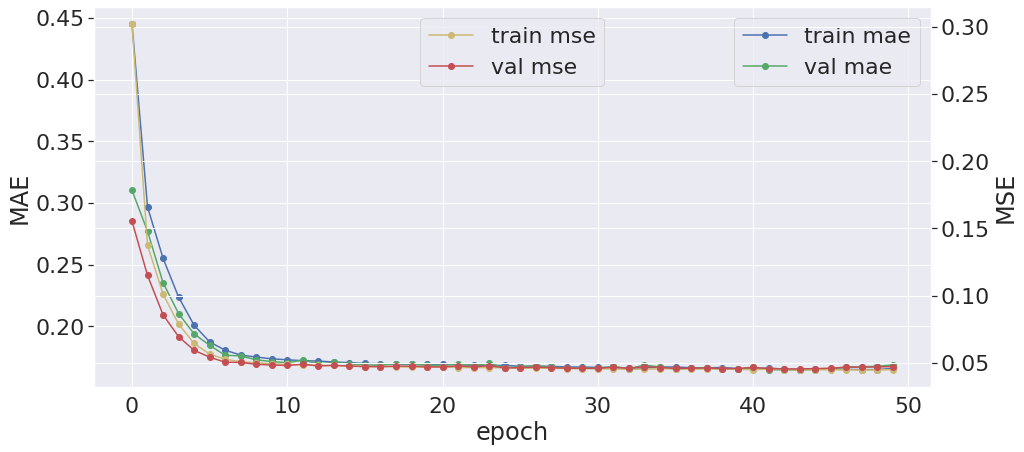

In [21]:
reg_history = pd.DataFrame(reg_history.history)

fig, mae_ax = plt.subplots(figsize=(15,7))

mse_ax = mae_ax.twinx()

mae_ax.plot(reg_history['mae'], 'b',marker='o', label='train mae')
mae_ax.plot(reg_history['val_mae'], 'g',marker='o', label='val mae')

mse_ax.plot(reg_history['loss'], 'y',marker='o', label='train mse')
mse_ax.plot(reg_history['val_loss'], 'r',marker='o', label='val mse')

mae_ax.set_xlabel('epoch')
mae_ax.set_ylabel('MAE')
mse_ax.set_ylabel('MSE')

mae_ax.legend(loc='upper right')
mse_ax.legend(loc='upper center')

plt.show()

5.3. 실제값과 예측값을 비교하기

In [22]:
mse, mae = reg_model.evaluate(test_X0, test_Y0)

reg_predictions = reg_model.predict(test_X0)

print("테스트 데이터의 mae 값: ", mae)
for i in range(10):
    print("%d 번째 데이터의 [실제값,예측값] : [%f,%f]"\
          % (i, test_Y0.iloc[i],reg_predictions[i]))

188/188 [==============================] - 0s 909us/step - loss: 0.0452 - mae: 0.1640
테스트 데이터의 mae 값:  0.1639855057001114
0 번째 데이터의 [실제값,예측값] : [-1.541241,-1.428831]
1 번째 데이터의 [실제값,예측값] : [-1.828186,-1.460485]
2 번째 데이터의 [실제값,예측값] : [-1.511858,-1.451670]
3 번째 데이터의 [실제값,예측값] : [-1.807237,-1.471010]
4 번째 데이터의 [실제값,예측값] : [-1.792150,-1.439568]
5 번째 데이터의 [실제값,예측값] : [-1.798603,-1.468053]
6 번째 데이터의 [실제값,예측값] : [-1.707412,-1.520713]
7 번째 데이터의 [실제값,예측값] : [-1.755896,-1.551920]
8 번째 데이터의 [실제값,예측값] : [-1.669383,-1.494728]
9 번째 데이터의 [실제값,예측값] : [-1.430415,-1.633443]


5.4. 실제값과 예측값의 차이를 DataFrame으로 지정합니다.

In [23]:
error = pd.DataFrame(columns=["Real","Predict"])
error['Real'] = test_Y0 ; error['Predict'] = reg_predictions
error['error'] = abs(error['Real'] - error['Predict']) # 단순한 값의 차이
error['error_ratio'] = (10**error['Predict'])/(10**error['Real']) # 비율상으로 얼마나 차이가 나는 것인지

error = error.join(test_XX[para])

5.5. 시간에 따라서 실제값과 예측값을 그려봅니다.

(array([730120., 730180., 730241., 730302., 730364., 730425., 730486.]),
 <a list of 7 Text major ticklabel objects>)

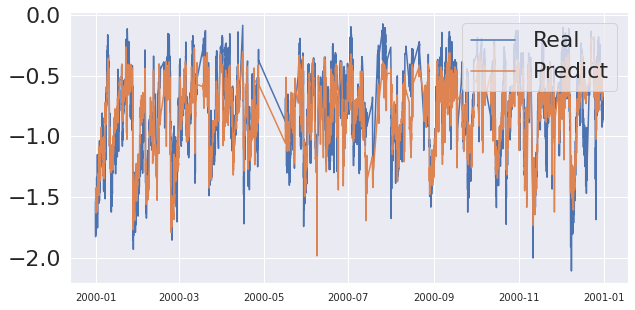

In [24]:
plt.figure(figsize=(10,5))
plt.plot(error['Real'],label='Real')
plt.plot(error['Predict'],label='Predict')
plt.legend(loc='upper right');plt.xticks(fontsize=10)

(730120.0, 730151.0)

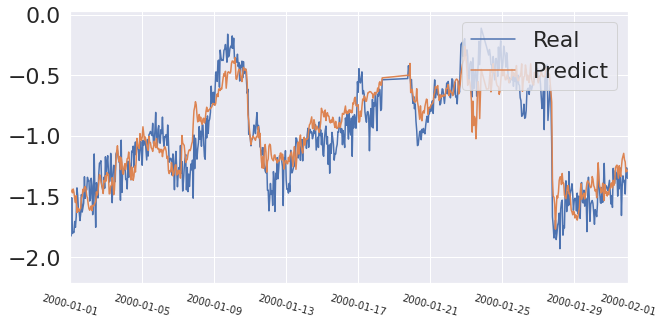

In [25]:
plt.figure(figsize=(10,5))
plt.plot(error['Real'],label='Real')
plt.plot(error['Predict'],label='Predict')
plt.legend(loc='upper right');plt.xticks(fontsize=10,rotation=-15)
plt.xlim(datetime(2000,1,1),datetime(2000,2,1))

5.6. 실제값과 예측값이 1대1 대응을 하는 것인지 y=x 그래프를 통해 파악합니다.
- 회색선은 값 차이가 0.25이상의 경계선을 의미합니다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-2.0, 0.0)

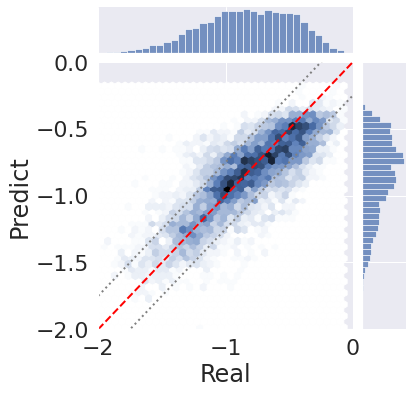

In [26]:
sns.jointplot("Real","Predict",error,kind='hex')
plt.plot([-2,0],[-2,0],linestyle='--',linewidth=2,color='red')
plt.plot([-2,0],[-1.75,0.25],linestyle=':',linewidth=2,color='grey')
plt.plot([-2,0],[-2.25,-0.25],linestyle=':',linewidth=2,color='grey')
plt.xlim(-2,0);plt.ylim(-2,0)

5.6.1 실제값중에서 어떤 곳에서 가장 많은 에러를 발생하는 것인지 조사합니다.
- 빨간 점선은 0.25이상의 경계선을 나타냅니다.
- 전체 데이터중에서 에러값이 0.25이하인 데이터의 비율을 파악합니다.

Error 0.25이하 : 78.11%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 1.0)

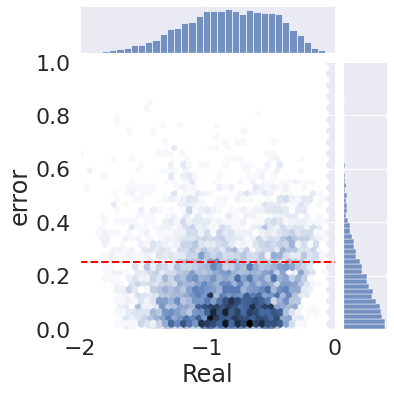

In [27]:
percen = 100*error[error['error'] <= 0.25]['error'].count()/error['error'].count()
print("Error 0.25이하 : {}%".format(round(percen,2)))
sns.jointplot("Real","error",error,kind='hex')
plt.axhline(0.25,linestyle='--',linewidth=2,color='red')
plt.xlim(-2,0);plt.ylim(0,1)

5.6.2. 실제값중에서 어떤 곳에서 가장 많은 에러를 발생하는 것인지 히스토그램을 그려봅니다.
- 빨간 히스토그램은 에러값 0.25이상인 데이터의 히스토그램을 나타냅니다.

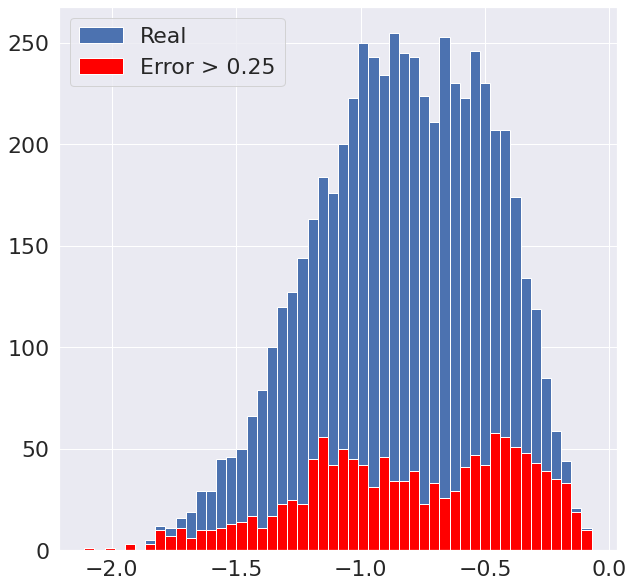

In [28]:
plt.figure(figsize=(10,10))

plt.hist(error['Real'],bins=50,label='Real')
plt.hist(error[error['error'] > 0.25]['Real'],bins=50,color='red',label='Error > 0.25')
plt.legend()

# <결과>

1. 플라즈마 이진분류에서 약 82%의 정확도를 보여주고 있으며 서로 겹쳐지는 영역에서 제대로 분류하지 못하는 모습을 보입니다.

2. 다른 변수도 훈련 데이터에 넣어봤지만 82%이상의 정확도는 보여주지 못합니다.

3. Real 데이터의 분류는 2009년에 플라즈마의 속도와 플라즈마의 산소 이온 비율(Oxygen Ratio)을 통해 Zhou et al. 2008에서 분류 됐습니다.

4. 플라즈마 상태만을 이용하여 과학적으로 의미가 있는 이온 비율(산소 이온 비율)을 생산 해보았습니다. 에러값이 작은 0.25이하의 비율은 약 78%이며, 대부분 데이터가 없는 부분에서 잘 추측하지 못하는 것을 확인할 수 있었습니다.

5. 데이터의 비율을 증가시키고 추가적으로 데이터 전처리 과정에서 좀 더 깔끔하게 처리할 수 있다면 좀 더 좋은 성능을 보일 수 있을 것이며 추가적인 연구 과정에서도 이용할 수 있을 것으로 판단됩니다.